# 3 - Bike Sharing Prediction

## Task description:

* **Training data**: whole 2011 and first 3 quarters of 2012.
* **Test data**: 4th quarter of 2012.  Do not fit your models with these data! They should just be used to see how good/bad your model predictions are.
* **Error metric**: R2 score (scikit-learn's default for regression).
* **Features to use**: at least the ones present in the data (except for cnt). Do not use both casual and registered columns, as cnt=casual+registered (you may use one, but not both). Additionally, you can use other sources of data you deem appropriate to predict from extra features.

## Exploratory Data Analysis (descriptive analytics) (4 points)

The first step of the analysis is to get familiar with the data. After importing the datasets we perform some analysis to have a general idea about the data. 
* **.head**: to understand the columns of the datasets
* **.describe**: to understand the distribution of the data 

In [1]:
import zipfile
import requests 
import io 
import re
import pandas as pd
import numpy as np

import dask
import dask.dataframe as dd
import time
start = time.time()

def print_time(sec):
    return time.strftime("%H:%M:%S", time.gmtime(sec))
    
print (print_time(start))

06:35:16


In order to predict the feature cnt we need to delete casual and registered (being these variable sub classes of cnt)

In [2]:
#!pip install kaggle
#!kaggle datasets list -s bike-sharing-dataset
!kaggle datasets download -d marklvl/bike-sharing-dataset --force


  0%|          | 0.00/273k [00:00<?, ?B/s]
100%|##########| 273k/273k [00:00<00:00, 5.02MB/s]


In [3]:
from dask.distributed import Client, progress
client = Client(n_workers=2, threads_per_worker=2, memory_limit='4GB')
client

Client Scheduler: tcp://127.0.0.1:61650 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 8.00 GB


In [4]:
from dask import delayed
from io import BytesIO
zfname = 'bike-sharing-dataset.zip'

with zipfile.ZipFile(zfname) as zfile:
    for name in zfile.namelist():

        if re.search(r'\.zip$', name) is not None:
            # We have a zip within a zip
            zfiledata = BytesIO(zfile.read(name))
            with zipfile.ZipFile(zfiledata) as zfile2:
                dayPandas = pd.read_csv(zfile2.open("day.csv"))
                hourPandas = pd.read_csv(zfile2.open("hour.csv")).drop(columns=['casual', 'registered'])

day = delayed(dayPandas)
hour = delayed(hourPandas)  

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("ggplot")

0.9.0


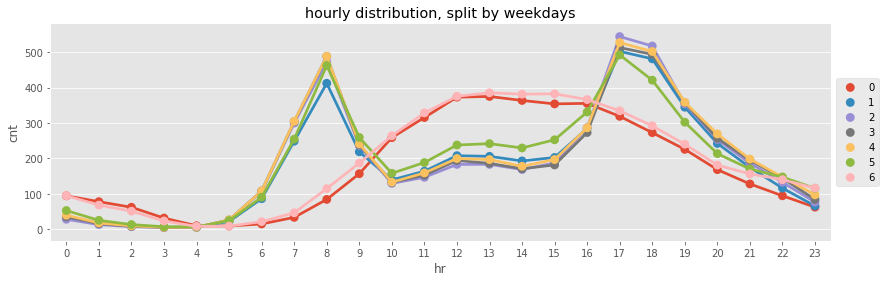

In [9]:
# here we plot the hourly distribution of the bike ride count by weekdays, to understand daily usage patterns
plt.figure(figsize=(14, 4))
weekday_hr_gb = hour.groupby(["weekday", "hr"]).mean()["cnt"].reset_index(drop=False).compute()
sns.pointplot(x="hr", y="cnt", hue="weekday", data=weekday_hr_gb)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("hourly distribution, split by weekdays")
plt.show()

We notice the following: 
- weekdays - peaks are mornings and evenings
- weekends - peaks are during the day

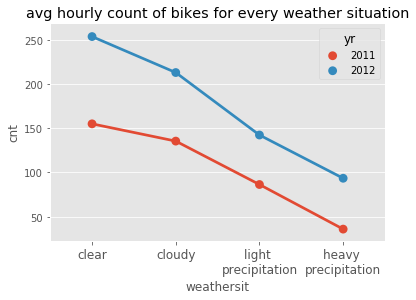

In [10]:
weathersit_gb = hour.groupby(["weathersit", "yr"]).mean()["cnt"].reset_index(drop=False).compute()
weathersit_gb["yr"].replace([0, 1], [2011, 2012], inplace=True)
sns.pointplot(hue="yr", x="weathersit", y="cnt", data=weathersit_gb)
plt.title("avg hourly count of bikes for every weather situation")
plt.xticks(
    range(4),
    ["clear", "cloudy", "light \nprecipitation", "heavy \nprecipitation"],
    rotation=0,
    fontsize="12",
)
plt.show()

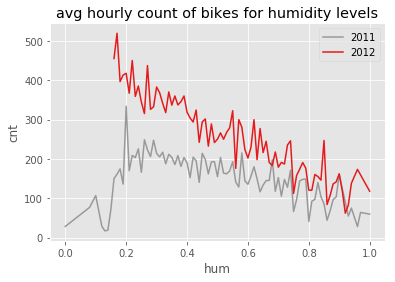

In [11]:
hum_gb = hour.groupby(["hum", "yr"]).mean()["cnt"].reset_index(drop=False).compute()
hum_gb["yr"].replace([0, 1], [2011, 2012], inplace=True)
sns.lineplot("hum", "cnt", hue="yr", data=hum_gb, palette="Set1_r")
# sb.lineplot('hum','cnt',data=hum_gb[hum_gb['yr']==2012])
plt.title("avg hourly count of bikes for humidity levels")
plt.legend([2011, 2012])
plt.show()

We have reasons to suspect correlation. The more humid it is, the less bikes are being rented out in 2011 the trend looks a bit different - where humidity is very low also less bikes are being used together with year it has some connection to our target value


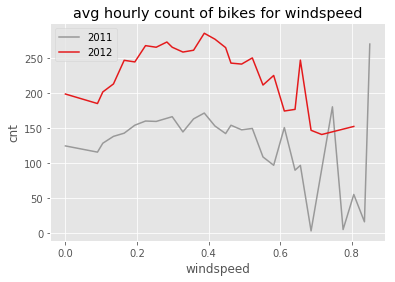

In [12]:
windspeed_gb = hour.groupby(["windspeed", "yr"]).mean()["cnt"].reset_index(drop=False).compute()
windspeed_gb["yr"].replace([0, 1], [2011, 2012], inplace=True)
sns.lineplot("windspeed", "cnt", hue="yr", data=windspeed_gb, palette="Set1_r")
plt.title("avg hourly count of bikes for windspeed")
plt.legend([2011, 2012])
plt.show()

As expected, there is no significant trend here to be seen

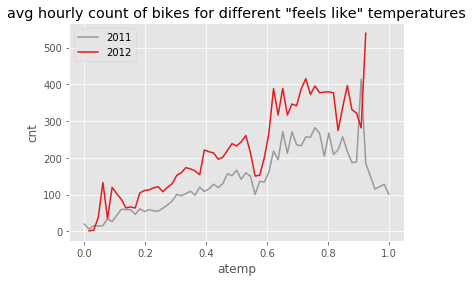

In [13]:
atemp_gb = hour.groupby(["atemp", "yr"]).mean()["cnt"].reset_index(drop=False).compute()
atemp_gb["yr"].replace([0, 1], [2011, 2012], inplace=True)
sns.lineplot(hue="yr", x="atemp", y="cnt", data=atemp_gb, palette="Set1_r")
plt.title('avg hourly count of bikes for different "feels like" temperatures')
plt.legend([2011, 2012])
plt.show()

We see that the warmer it feels, the more bikes are being used but only up to a certain temperature. When it starts feeling very warm, less bikes are being rented out

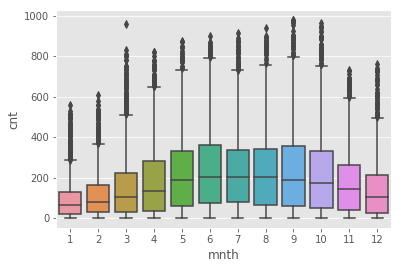

In [14]:
# here we will plot the count of rides per month, while also representing its distribution
ax = sns.boxplot(x="mnth", y="cnt", data=hour.compute())

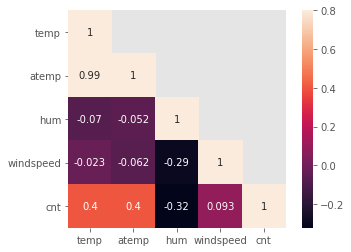

In [15]:
# Here we plot the correlations among variables through a heatmap, which will be useful during the feature engineering phase.
corrMatt = hour[["temp", "atemp", "hum", "windspeed", "cnt"]].compute().corr()

mask = np.array(corrMatt)
# Turning the lower-triangle of the array to false
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
sns.heatmap(corrMatt, mask=mask, vmax=0.8, square=True, annot=True, ax=ax)

plt.show()

## Data Cleaning
Here we star with cleaning the data. 
* **Step 1:** We split the variables into categorical and numerical to understand what variable can undergo what transformation
* **Step 2:** We check for NAs
* **Step 3:** We plot the different variables as boxplots to get a sense of the outlier distribution. 

### Features class 

In order to improve the quality of the predictions, it is possible to transform wrongly encoded numerical feature in categorical ones. In this case "hr", "weekday", "mnth", "season", "weathersit", "holiday", "workingday" are encoded as numerical feature but they are clearly categorical. 

In [16]:
#here we split the variables into categorical and numerical under two different lists
from numpy import math
import numpy as np

catfeats = pd.DataFrame(hour.describe(include=["O"]).compute()).columns
numfeats = list(hour.select_dtypes(include=[np.number]).columns.values.compute())

In [17]:
print(catfeats)

Index(['dteday'], dtype='object')


In [18]:
print(numfeats)

['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']


In [19]:
#here we coerce the variable type to categorical for these features
categoryVariableList = [
    "hr",
    "weekday",
    "mnth",
    "season",
    "weathersit",
    "holiday",
    "workingday",
]
for var in categoryVariableList:
    #hour[var] = dd.to_datetime(df.index, format='%Y/%m/%d %H:%M')
    hourPandas[var] = hourPandas[var].astype("category")

In [20]:
hourPandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null category
yr            17379 non-null int64
mnth          17379 non-null category
hr            17379 non-null category
holiday       17379 non-null category
weekday       17379 non-null category
workingday    17379 non-null category
weathersit    17379 non-null category
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
cnt           17379 non-null int64
dtypes: category(7), float64(4), int64(3), object(1)
memory usage: 1.2+ MB


### NAs

As it is possible to notice there are not NAs in the dataset. Therefore, no further action is required. 

In [21]:
#here we go hunting for NAs
for column in hourPandas:
    NAs = hourPandas[column].isnull().sum()
    print(column + " " + str(NAs))

instant 0
dteday 0
season 0
yr 0
mnth 0
hr 0
holiday 0
weekday 0
workingday 0
weathersit 0
temp 0
atemp 0
hum 0
windspeed 0
cnt 0


### Outliers 
Here we have a look on the outliers. We will however not exclude any, as after iterating, we understood that we get better results withouth doing that. 

In [22]:
def show_outlier():
    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.set_size_inches(12, 10)
    sns.boxplot(data=hourPandas, y="cnt", orient="v", ax=axes[0][0])
    sns.boxplot(data=hourPandas, y="cnt", x="season", orient="v", ax=axes[0][1])
    sns.boxplot(data=hourPandas, y="cnt", x="hr", orient="v", ax=axes[1][0])
    sns.boxplot(data=hourPandas, y="cnt", x="workingday", orient="v", ax=axes[1][1])

    axes[0][0].set(ylabel="Count", title="Box Plot On Count")
    axes[0][1].set(xlabel="Season", ylabel="Count", title="Box Plot On Count Across Season")
    axes[1][0].set(
        xlabel="Hour Of The Day",
        ylabel="Count",
        title="Box Plot On Count Across Hour Of The Day",
    )
    axes[1][1].set(
        xlabel="Working Day", ylabel="Count", title="Box Plot On Count Across Working Day"
    )

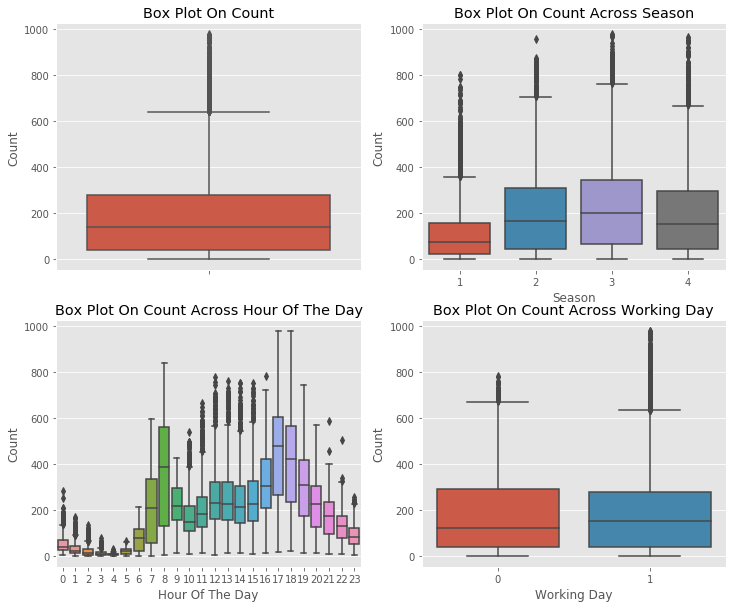

In [23]:
show_outlier()

## Feature Engineering
Here we switch the original columns, with some dummy ones, so to fit the format needs of our algorithms. 

In [24]:
def generate_dummies(df, dummy_column):
    dummies = pd.get_dummies(df[dummy_column], prefix=dummy_column)
    df = pd.concat([df, dummies], axis=1)
    return df

In [25]:
hour_m = pd.DataFrame.copy(hourPandas)
dummy_columns = ["season", "yr", "mnth", "hr", "weekday", "weathersit"]
for dummy_column in dummy_columns:
    hour_m = generate_dummies(hour_m, dummy_column)

In [26]:
# remove the original categorical variables: "season", "yr", "mnth", "hr", "weekday", "weathersit"
for dummy_column in dummy_columns:
    del hour_m[dummy_column]

In [27]:
## drop also the variables 'instant' since it is irrelevant
del hour_m['instant']

In [28]:
hour_m.head()

,dteday,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_1,season_2,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,2011-01-01,0,0,0.24,0.2879,0.81,0.0,16,1,0,...,0,0,0,0,0,1,1,0,0,0
1,2011-01-01,0,0,0.22,0.2727,0.80,0.0,40,1,0,...,0,0,0,0,0,1,1,0,0,0
2,2011-01-01,0,0,0.22,0.2727,0.80,0.0,32,1,0,...,0,0,0,0,0,1,1,0,0,0
3,2011-01-01,0,0,0.24,0.2879,0.75,0.0,13,1,0,...,0,0,0,0,0,1,1,0,0,0
4,2011-01-01,0,0,0.24,0.2879,0.75,0.0,1,1,0,...,0,0,0,0,0,1,1,0,0,0


In [29]:
# Back to Dask.
hour = delayed(hour_m)
day = delayed(dayPandas)

## Machine Learning (predictive analytics) (5 points)

In this part, we start applying the different models we want to apply. The order of this subchapter is the following:
* **Step 1: Train and test split**
* **Step 2: Regression model**
* **Step 3: Random forest**
* **Step 4: XGBoost**
* **Step 5: Combining models**
* **Step 6: Pipeline**


### Training test split

In [30]:
# here we create the training set from the complete dataset we have, using the date as filtering item
X_train = hour.loc[hour_m["dteday"] < "2012-10-1"].compute()
del X_train["cnt"]
del X_train["dteday"]
X_train.head()

,holiday,workingday,temp,atemp,hum,windspeed,season_1,season_2,season_3,season_4,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,0,0,0.24,0.2879,0.81,0.0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1,0,0,0.22,0.2727,0.80,0.0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2,0,0,0.22,0.2727,0.80,0.0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
3,0,0,0.24,0.2879,0.75,0.0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
4,0,0,0.24,0.2879,0.75,0.0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0


In [31]:
# here we create the test set from the complete dataset we have, using the date as filtering item
X_test = hour.loc[hour_m["dteday"] >= "2012-10-1"].compute()
del X_test["cnt"]
del X_test["dteday"]
X_test.head()

,holiday,workingday,temp,atemp,hum,windspeed,season_1,season_2,season_3,season_4,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,weathersit_4
15427,0,1,0.46,0.4545,0.88,0.0896,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
15428,0,1,0.46,0.4545,0.88,0.0000,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
15429,0,1,0.46,0.4545,0.88,0.0000,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
15430,0,1,0.46,0.4545,0.88,0.0000,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
15431,0,1,0.46,0.4545,0.88,0.1045,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0


In [32]:
y_train = hour.loc[hour_m["dteday"] < "2012-10-1"]["cnt"].compute()
y_train.head()

0    16
1    40
2    32
3    13
4     1
Name: cnt, dtype: int64

In [33]:
y_test = hour.loc[hour_m["dteday"] >= "2012-10-1"]["cnt"].compute()
y_test.head()

15427    33
15428     8
15429     8
15430     6
15431     6
Name: cnt, dtype: int64

## Regression Model
Here we run our regression model, which is the first model we want to try as if with such a simple one we get good results, we would prefer it over more complex ones. 

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

#!pip install dask_ml

In [35]:
# Create linear regression object

#from sklearn.externals import joblib # Deprecated. import joblib recommended.
#!pip install joblib
import joblib
# Create linear regression object
regr = linear_model.LinearRegression()

with joblib.parallel_backend('dask'):
    regr.fit(X_train, y_train)

In [36]:
# Make predictions using the testing set
with joblib.parallel_backend('dask'):
    y_pred_rm = regr.predict(X_test)

In [37]:
# here we calculate the r^2 for the model
with joblib.parallel_backend('dask'):
    r2_rm = r2_score(y_test, y_pred_rm)
    r2_rm.round(2)

In [38]:
#with joblib.parallel_backend('dask'):
accuracy_rm = cross_val_score(estimator=regr, X=X_train, y=y_train, cv=5)
accuracy_rm[1].round(2)

0.68

Lets compare the distribution of train and test results. the distribution of train and test looks very different. It confirms visually that our model has not predicted really in a proper way cnt.

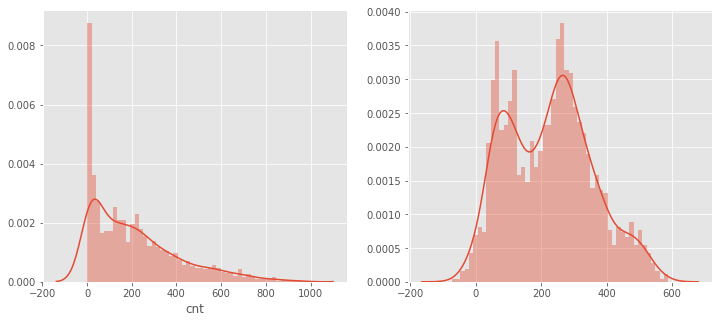

In [39]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
sns.distplot(y_test, ax=ax1, bins=50)
sns.distplot((y_pred_rm), ax=ax2, bins=50)

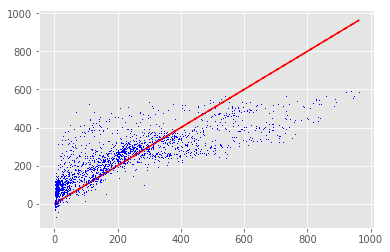

In [40]:
plt.plot(y_test, y_test, "r--", y_test, y_pred_rm, "b,")
plt.show()

### Random forest
Here we run out random forest model. Also, using grid_search, we find the best parameters for this model. 

In [41]:
# Grid Search
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [42]:
regressor = RandomForestRegressor()
parameters = [
    {"n_estimators": [150, 200, 250, 300], "max_features": ["auto", "sqrt", "log2"]}
]
grid_search = GridSearchCV(estimator=regressor, param_grid=parameters, cv=3)

# Create linear regression object
with joblib.parallel_backend('dask'):
    grid_search = grid_search.fit(X_train, y_train)
    best_parameters = grid_search.best_params_
    best_accuracy = grid_search.best_score_

In [43]:
best_parameters

{'max_features': 'auto', 'n_estimators': 150}

In [44]:
# Random Forest Regression model
# Use the best parameters found from above to build the model
regressor = grid_search.best_estimator_
with joblib.parallel_backend('dask'):
    # Predicting the values
    y_pred_rf = regressor.predict(X_test)

In [45]:
r2_rf = r2_score(y_test, y_pred_rf)
r2_rf.round(2)

0.85

In [46]:
## To modify from here below ... to use dask.



In [47]:
# Using k-fold cross validation to evaluate the performance of the model
regressor = grid_search.best_estimator_
with joblib.parallel_backend('dask'):
    accuracy_rf = cross_val_score(estimator=regressor, X=X_train, y=y_train, cv=3)
    accuracy_rf = accuracy_rf.mean()
    
    # Relative importance of features
    feature_importance = regressor.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    
    accuracy_rf.round(2)

In [48]:
 accuracy_rf.round(2)

0.72

Here we plot the variable importance to get a grasp of what the most important ones are, and the relative importance of each one as well.

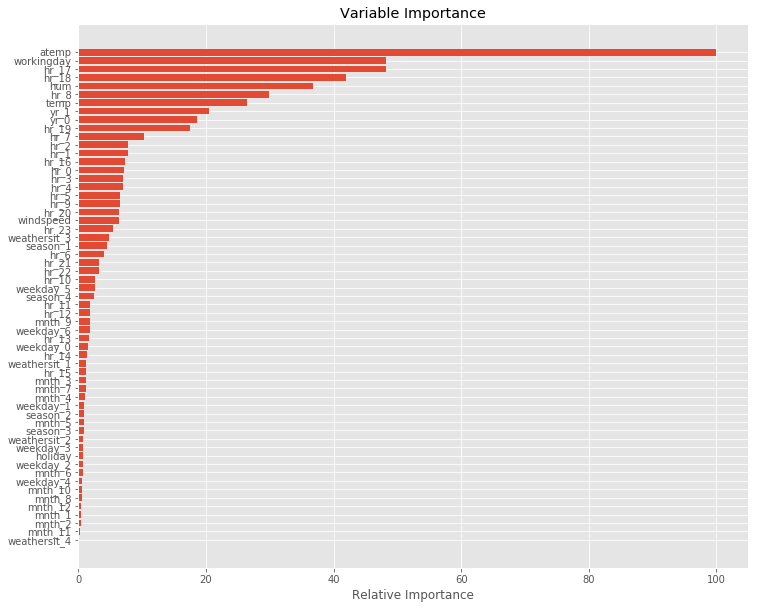

In [49]:
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.figure(figsize=(12, 10))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

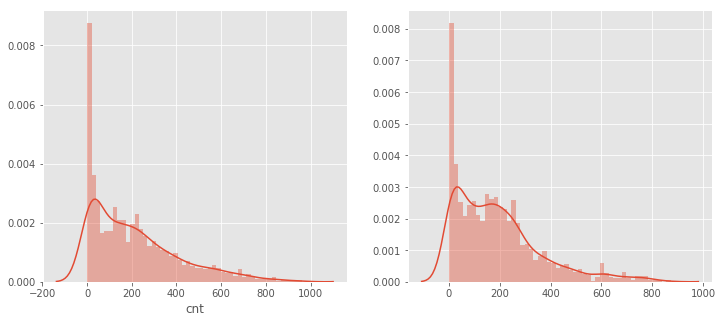

In [50]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
sns.distplot((y_test), ax=ax1, bins=50)
sns.distplot((y_pred_rf), ax=ax2, bins=50)

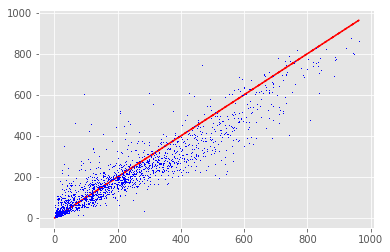

In [51]:
plt.plot(y_test, y_test, 'r--', y_test, y_pred_rf, 'b,')
plt.show()

### XGBoost
Here we run the XGBoost model. 

In [52]:
!pip install xgboost

In [53]:
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [54]:
# here we coerce the variable type to 'int' to let XGBoost run
X_train["holiday"] = X_train.holiday.astype("int")
X_train["workingday"] = X_train.workingday.astype("int")

In [55]:
# here we coerce the variable type to 'int' to let XGBoost run
X_test["holiday"] = X_test.holiday.astype("int")
X_test["workingday"] = X_test.workingday.astype("int")

C:\Users\ajukg\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ajukg\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


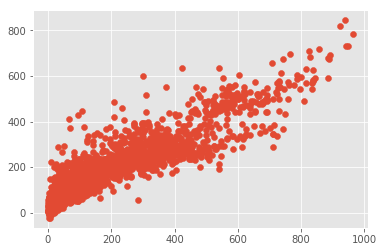

In [56]:
xgb_model = xgb.XGBRegressor(
    objective="reg:linear",
    random_state=42,
    colsample_bytree=0.3,
    learning_rate=0.1,
    max_depth=5,
    alpha=10,
)

with joblib.parallel_backend('dask'):
    xgb_model.fit(X_train, y_train)
    y_pred_xgb_standard = xgb_model.predict(X_test)
    plt.scatter(y_test, y_pred_xgb_standard)
    r2_xgb_standard = r2_score(y_test, y_pred_xgb_standard)

In [57]:
with joblib.parallel_backend('dask'):
    accuracy_xgb_model = cross_val_score(estimator=xgb_model, X=X_train, y=y_train, cv=5)
    accuracy_xgb_model = accuracy_xgb_model.mean()
    accuracy_xgb_model.round(2)

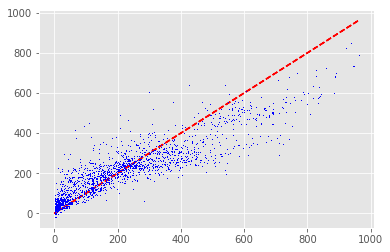

In [58]:
plt.plot(y_test, y_test, 'r--', y_test, y_pred_xgb_standard, 'b,')
plt.show()

In [59]:
# tuning Hyperparameters
parameters_xgb = [
    {
        "n_estimators": [500, 1000],
        "max_depth": [4, 8, 12],
        "colsample_bytree": [0.4, 0.8],
    }
]

with joblib.parallel_backend('dask'):
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=parameters_xgb, cv=3)
    grid_search = grid_search.fit(X_train, y_train)
    best_parameters_xgb = grid_search.best_params_

C:\Users\ajukg\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ajukg\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [60]:
best_parameters_xgb

{'colsample_bytree': 0.4, 'max_depth': 4, 'n_estimators': 1000}

In [61]:
# finetuned_model
#model = xgb.XGBRegressor(max_depth=4, n_estimators=1000, colsample_bytree=0.4, seed=42)
model = grid_search.best_estimator_

with joblib.parallel_backend('dask'):
    model.fit(
        X_train,
        y_train,
        eval_metric="rmse",
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=True,
        early_stopping_rounds=10,
    )
    # here we do the actual prediction using
    y_pred_xgb = model.predict(X_test)

[0]	validation_0-rmse:240.602	validation_1-rmse:272.296
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.


C:\Users\ajukg\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ajukg\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[1]	validation_0-rmse:224.566	validation_1-rmse:261.498
[2]	validation_0-rmse:211.038	validation_1-rmse:251.566
[3]	validation_0-rmse:198.477	validation_1-rmse:235.088
[4]	validation_0-rmse:187.549	validation_1-rmse:227.969
[5]	validation_0-rmse:177.984	validation_1-rmse:219.612
[6]	validation_0-rmse:169.742	validation_1-rmse:213.314
[7]	validation_0-rmse:162.207	validation_1-rmse:202.935
[8]	validation_0-rmse:156.137	validation_1-rmse:199.032
[9]	validation_0-rmse:150.836	validation_1-rmse:191.576
[10]	validation_0-rmse:145.004	validation_1-rmse:186.728
[11]	validation_0-rmse:140.461	validation_1-rmse:182.806
[12]	validation_0-rmse:136.105	validation_1-rmse:178.057
[13]	validation_0-rmse:132.598	validation_1-rmse:175.231
[14]	validation_0-rmse:129.059	validation_1-rmse:170.609
[15]	validation_0-rmse:126.257	validation_1-rmse:168.554
[16]	validation_0-rmse:123.693	validation_1-rmse:165.67
[17]	validation_0-rmse:121.34	validation_1-rmse:163.9
[18]	validation_0-rmse:119.122	validation_1-

[145]	validation_0-rmse:62.6268	validation_1-rmse:90.5682
[146]	validation_0-rmse:62.5689	validation_1-rmse:90.5214
[147]	validation_0-rmse:62.458	validation_1-rmse:90.4184
[148]	validation_0-rmse:62.3052	validation_1-rmse:90.3167
[149]	validation_0-rmse:62.2223	validation_1-rmse:90.2708
[150]	validation_0-rmse:62.0921	validation_1-rmse:90.1798
[151]	validation_0-rmse:61.6171	validation_1-rmse:89.7611
[152]	validation_0-rmse:61.5232	validation_1-rmse:89.6887
[153]	validation_0-rmse:61.4306	validation_1-rmse:89.5971
[154]	validation_0-rmse:61.3658	validation_1-rmse:89.5012
[155]	validation_0-rmse:61.3004	validation_1-rmse:89.3853
[156]	validation_0-rmse:61.2399	validation_1-rmse:89.3415
[157]	validation_0-rmse:61.0725	validation_1-rmse:89.1816
[158]	validation_0-rmse:60.9634	validation_1-rmse:89.052
[159]	validation_0-rmse:60.9346	validation_1-rmse:89.0087
[160]	validation_0-rmse:60.8765	validation_1-rmse:88.9497
[161]	validation_0-rmse:60.8332	validation_1-rmse:88.9056
[162]	validation

[287]	validation_0-rmse:48.1684	validation_1-rmse:78.105
[288]	validation_0-rmse:48.1336	validation_1-rmse:78.0728
[289]	validation_0-rmse:47.8589	validation_1-rmse:77.7463
[290]	validation_0-rmse:47.8061	validation_1-rmse:77.7378
[291]	validation_0-rmse:47.7801	validation_1-rmse:77.7243
[292]	validation_0-rmse:47.7547	validation_1-rmse:77.7376
[293]	validation_0-rmse:47.6548	validation_1-rmse:77.6327
[294]	validation_0-rmse:47.5827	validation_1-rmse:77.5829
[295]	validation_0-rmse:47.3839	validation_1-rmse:77.3841
[296]	validation_0-rmse:47.3616	validation_1-rmse:77.3715
[297]	validation_0-rmse:47.3368	validation_1-rmse:77.2634
[298]	validation_0-rmse:47.299	validation_1-rmse:77.2198
[299]	validation_0-rmse:47.2828	validation_1-rmse:77.2202
[300]	validation_0-rmse:47.264	validation_1-rmse:77.221
[301]	validation_0-rmse:47.1273	validation_1-rmse:77.0993
[302]	validation_0-rmse:47.1115	validation_1-rmse:77.0879
[303]	validation_0-rmse:47.1004	validation_1-rmse:77.0813
[304]	validation_0

[429]	validation_0-rmse:43.2363	validation_1-rmse:74.2155
[430]	validation_0-rmse:43.2195	validation_1-rmse:74.1968
[431]	validation_0-rmse:43.199	validation_1-rmse:74.1967
[432]	validation_0-rmse:43.179	validation_1-rmse:74.1944
[433]	validation_0-rmse:43.1211	validation_1-rmse:74.1333
[434]	validation_0-rmse:43.1155	validation_1-rmse:74.1312
[435]	validation_0-rmse:43.1111	validation_1-rmse:74.1303
[436]	validation_0-rmse:43.0977	validation_1-rmse:74.1326
[437]	validation_0-rmse:43.0831	validation_1-rmse:74.1326
[438]	validation_0-rmse:43.0636	validation_1-rmse:74.1184
[439]	validation_0-rmse:43.0468	validation_1-rmse:74.0906
[440]	validation_0-rmse:43.0308	validation_1-rmse:74.0867
[441]	validation_0-rmse:42.988	validation_1-rmse:74.0517
[442]	validation_0-rmse:42.9228	validation_1-rmse:74.0041
[443]	validation_0-rmse:42.9142	validation_1-rmse:73.9969
[444]	validation_0-rmse:42.8921	validation_1-rmse:73.9751
[445]	validation_0-rmse:42.85	validation_1-rmse:73.9844
[446]	validation_0-

[571]	validation_0-rmse:40.148	validation_1-rmse:71.8635
[572]	validation_0-rmse:40.1239	validation_1-rmse:71.8477
[573]	validation_0-rmse:40.1196	validation_1-rmse:71.8479
[574]	validation_0-rmse:40.1152	validation_1-rmse:71.8491
[575]	validation_0-rmse:40.1014	validation_1-rmse:71.8316
[576]	validation_0-rmse:40.1003	validation_1-rmse:71.8304
[577]	validation_0-rmse:40.075	validation_1-rmse:71.7788
[578]	validation_0-rmse:40.0609	validation_1-rmse:71.7715
[579]	validation_0-rmse:40.0524	validation_1-rmse:71.7676
[580]	validation_0-rmse:40.0482	validation_1-rmse:71.7675
[581]	validation_0-rmse:40.0456	validation_1-rmse:71.7677
[582]	validation_0-rmse:40.0284	validation_1-rmse:71.7455
[583]	validation_0-rmse:40.0212	validation_1-rmse:71.7462
[584]	validation_0-rmse:40.0113	validation_1-rmse:71.7508
[585]	validation_0-rmse:40.0019	validation_1-rmse:71.7477
[586]	validation_0-rmse:39.9986	validation_1-rmse:71.7481
[587]	validation_0-rmse:39.9922	validation_1-rmse:71.7489
[588]	validation

[713]	validation_0-rmse:37.807	validation_1-rmse:70.0174
[714]	validation_0-rmse:37.7983	validation_1-rmse:69.99
[715]	validation_0-rmse:37.7777	validation_1-rmse:70.0318
[716]	validation_0-rmse:37.7711	validation_1-rmse:70.0282
[717]	validation_0-rmse:37.7353	validation_1-rmse:70.0194
[718]	validation_0-rmse:37.7182	validation_1-rmse:70.0038
[719]	validation_0-rmse:37.7049	validation_1-rmse:69.9911
[720]	validation_0-rmse:37.7042	validation_1-rmse:69.991
[721]	validation_0-rmse:37.6849	validation_1-rmse:69.9607
[722]	validation_0-rmse:37.6798	validation_1-rmse:69.9488
[723]	validation_0-rmse:37.6574	validation_1-rmse:69.9404
[724]	validation_0-rmse:37.649	validation_1-rmse:69.9398
[725]	validation_0-rmse:37.6346	validation_1-rmse:69.9204
[726]	validation_0-rmse:37.6173	validation_1-rmse:69.9186
[727]	validation_0-rmse:37.615	validation_1-rmse:69.9163
[728]	validation_0-rmse:37.5815	validation_1-rmse:69.8752
[729]	validation_0-rmse:37.5623	validation_1-rmse:69.8498
[730]	validation_0-r

[855]	validation_0-rmse:36.0673	validation_1-rmse:68.8364
[856]	validation_0-rmse:36.0616	validation_1-rmse:68.8351
[857]	validation_0-rmse:35.9978	validation_1-rmse:68.7495
[858]	validation_0-rmse:35.9807	validation_1-rmse:68.7232
[859]	validation_0-rmse:35.9608	validation_1-rmse:68.6922
[860]	validation_0-rmse:35.9524	validation_1-rmse:68.6816
[861]	validation_0-rmse:35.9325	validation_1-rmse:68.6488
[862]	validation_0-rmse:35.9259	validation_1-rmse:68.6295
[863]	validation_0-rmse:35.9169	validation_1-rmse:68.6255
[864]	validation_0-rmse:35.8933	validation_1-rmse:68.6155
[865]	validation_0-rmse:35.8781	validation_1-rmse:68.6102
[866]	validation_0-rmse:35.8591	validation_1-rmse:68.5756
[867]	validation_0-rmse:35.8547	validation_1-rmse:68.5719
[868]	validation_0-rmse:35.8412	validation_1-rmse:68.5696
[869]	validation_0-rmse:35.8247	validation_1-rmse:68.5691
[870]	validation_0-rmse:35.8158	validation_1-rmse:68.5733
[871]	validation_0-rmse:35.8126	validation_1-rmse:68.5685
[872]	validati

[997]	validation_0-rmse:34.6339	validation_1-rmse:67.8472
[998]	validation_0-rmse:34.6279	validation_1-rmse:67.8391
[999]	validation_0-rmse:34.6147	validation_1-rmse:67.8236


In [62]:
with joblib.parallel_backend('dask'):
    r2_xgb = r2_score(y_test, y_pred_xgb)
    r2_xgb.round(2)

In [63]:
with joblib.parallel_backend('dask'):
    accuracy_xgb = cross_val_score(estimator=xgb_model, X=X_train, y=y_train, cv=5)
    accuracy_xgb = accuracy_xgb.mean()
    accuracy_xgb.round(2)

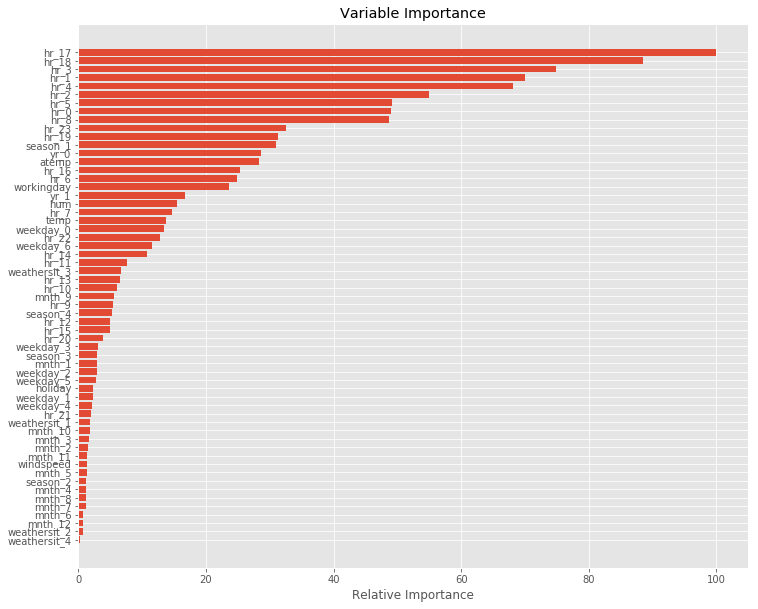

In [64]:
# Relative importance of features
feature_importance = model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.figure(figsize=(12, 10))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

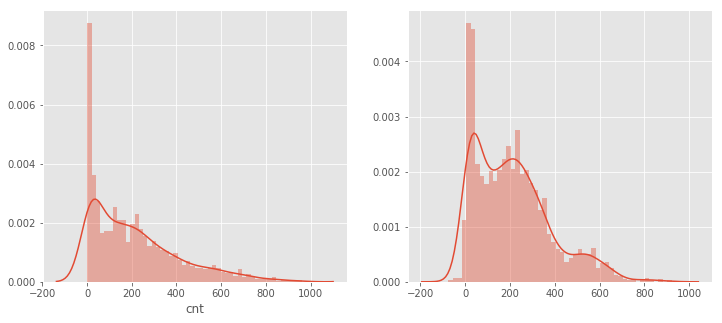

In [65]:
# here we plot to estimate the goodness of our prediction
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
sns.distplot(y_test, ax=ax1, bins=50)
sns.distplot((y_pred_xgb), ax=ax2, bins=50)

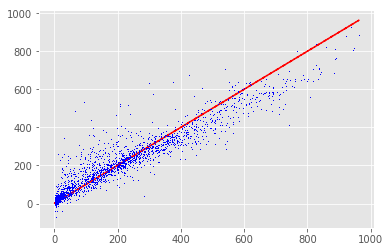

In [66]:
plt.plot(y_test, y_test, 'r--', y_test, y_pred_xgb, 'b,')
plt.show()

## Combining Models
In this section we combine some models, to see if we manage to achieve better results than the ones of the model which alone achieves the best results. We use random forest, gradient boosting and extra trees. 

In [67]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble
from sklearn.metrics import r2_score

In order to make this happen given limited computational power, we resized the dataset. This code therefore serves to  improve the running time and testing the code quality rather than given actual predictions.

In [68]:
X_train_sample = hour_m[0:688]  # one month as training data
del X_train_sample["cnt"]
del X_train_sample["dteday"]

X_test_sample = hour_m.loc[688:829]  # one week to be predicted
del X_test_sample["cnt"]
del X_test_sample["dteday"]

y_train_sample = hour_m[0:688]["cnt"]

y_test_sample = hour_m[688:830]["cnt"]

In [69]:
# here we define the models
rf = ensemble.RandomForestClassifier()
gbm = ensemble.GradientBoostingClassifier()
et = ensemble.ExtraTreesClassifier()

combo = ensemble.VotingClassifier(
    estimators=[("rf", rf), ("gbm", gbm), ("et", et)],
    voting="soft",
    weights=[3, 5, 2],
    n_jobs=10,
)

with joblib.parallel_backend('dask'):
    combo.fit(X_train_sample, y_train_sample)
    #here we do the prediction
    y_pred_combo = combo.predict(X_test_sample)
    # here we measure the r^2
    r2_combo = r2_score(y_test_sample, y_pred_combo)
    r2_combo.round(2)
    
    # here we measure the accuracy
    accuracy_combo = cross_val_score(
        estimator=combo, X=X_train_sample, y=y_train_sample, cv=5
    )
    accuracy_combo = accuracy_combo.mean()
    accuracy_combo.round(2)

C:\Users\ajukg\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


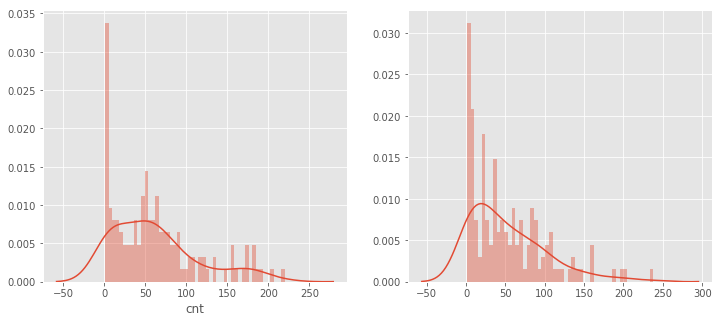

In [70]:
# here we plot our predictions' distribution vs. the actual distribution to estimate the goodness of the model.
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
sns.distplot(y_test_sample, ax=ax1, bins=50)
sns.distplot((y_pred_combo), ax=ax2, bins=50)

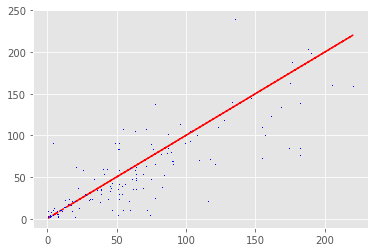

In [71]:
plt.plot(y_test_sample, y_test_sample, 'r--', y_test_sample, y_pred_combo, 'b,')
plt.show()

## Pipeline
Here we try to build a pipeline, where we figure out our best parameters for the logistic regression we run after it. 

In [72]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [73]:
steps = [('scaler', StandardScaler()), ('SVM', SVC())]
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps) # define the pipeline object.

In [74]:
parameteres = {'SVM__C':[0.001,0.1,10,100,10e5], 'SVM__gamma':[0.1,0.01]}

In [75]:
grid = GridSearchCV(pipeline, param_grid=parameteres, cv=5)
grid

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('SVM',
                                        SVC(C=1.0, cache_size=200,
                                            class_weight=None, coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='auto_deprecated',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False))],
                

In [76]:
X_train_sample["holiday"] = X_train_sample.holiday.astype("int")
X_train_sample["workingday"] = X_train_sample.workingday.astype("int")
X_test_sample["holiday"] = X_test_sample.holiday.astype("int")
X_test_sample["workingday"] = X_test_sample.workingday.astype("int")

C:\Users\ajukg\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\ajukg\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\ajukg\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [77]:
with joblib.parallel_backend('dask'):
    grid.fit(X_train_sample, y_train_sample)
print (grid.score(X_test_sample,y_test_sample))
print (grid.best_params_)

C:\Users\ajukg\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\ajukg\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.07746478873239436
{'SVM__C': 10, 'SVM__gamma': 0.1}


In [78]:
# Logistic Regression - Showing the Classification Report.
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression(
    C=10,
    class_weight=None,
    dual=False,
    fit_intercept=True,
    intercept_scaling=1,
    max_iter=200,
    multi_class="ovr",
    n_jobs=1,
    penalty="l2",
    random_state=None,
    solver="liblinear",
    tol=0.0001,
    verbose=0,
    warm_start=False,
)

with joblib.parallel_backend('dask'):
    logmodel.fit(X_train_sample, y_train_sample)

    # Predicting on Test
    y_pred_pip_sample = logmodel.predict(X_test_sample)

C:\Users\ajukg\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [79]:
r2_pip = r2_score(y_test_sample, y_pred_pip_sample)
r2_pip.round(2)

0.64

In [80]:
with joblib.parallel_backend('dask'):
    accuracy_pip = cross_val_score(estimator = logmodel, X = X_train_sample, y = y_train_sample, cv =5)
    accuracy_pip = accuracy_pip.mean()
    accuracy_pip.round(2)

C:\Users\ajukg\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Here we plot the distribution of the predictions and the actual distribution to see how similar they are. 

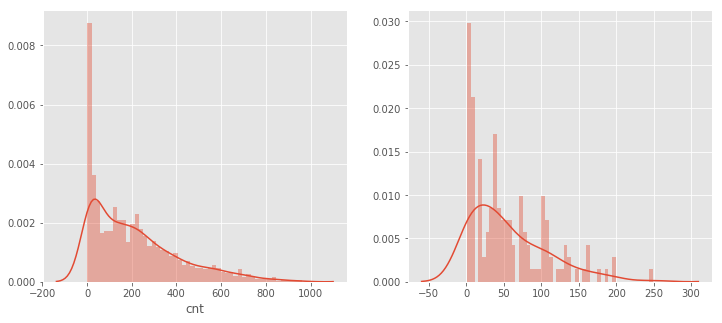

In [81]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
sns.distplot(y_test, ax=ax1, bins=50)
sns.distplot((y_pred_pip_sample), ax=ax2, bins=50)

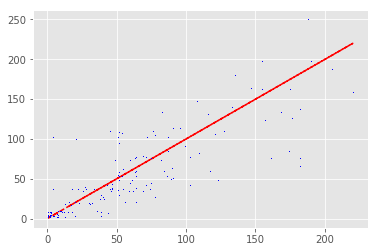

In [82]:
plt.plot(y_test_sample, y_test_sample, 'r--', y_test_sample, y_pred_pip_sample, 'b,')
plt.show()

## Wrap up
To sum up, here is once again the steps we went through: 
* **Step 1**: Exploratory data analysis: here we explore and get familiar with the data (graphically and numerically) 
    -  We plot the explanatory variables with the target variable to understand their relations graphically
* **Step 2**: Data cleaning: here we deal with outliers & NAs. 
   -  We change the class of certain variables to categorical to better fit our needs. Outliers did not need to be dropped as we get better results withouth this move. 
* **Step 3**: Feature engineering: we replace some of the columns with dummy columns in the right formats for our algorithms. 
* **Step 4**: Machine Learning: here we run different models individually, then we combine them and then we use a pipeline. 
    - Below a summary of the results of the various models

In [83]:
#here we summarize in a table the metrics of the various models we run to provide an overview
data = [
    {
        "regression": r2_rm,
        "random_forest": r2_rf,
        "xgb_standard": r2_xgb_standard,
        "xgb_tuned": r2_xgb,
        "combo*": r2_combo,
        "pipeline*": r2_pip,
    },
    {
        "regression": accuracy_rm[1],
        "random_forest": accuracy_rf,
        "xgb_standard": accuracy_xgb_model,
        "xgb_tuned": accuracy_xgb,
        "combo*": accuracy_combo,
        "pipeline*": accuracy_pip,
    },
]

models_comparison = pd.DataFrame(
    data,
    index=["r2", "accuracy"],
    columns=[
        "regression",
        "random_forest",
        "xgb_standard",
        "xgb_tuned",
        "combo*",
        "pipeline*",
    ],
)

In [84]:
models_comparison.round(2)

,regression,random_forest,xgb_standard,xgb_tuned,combo*,pipeline*
r2,0.63,0.85,0.78,0.88,0.64,0.64
accuracy,0.68,0.72,0.77,0.77,0.05,0.05


In [85]:
# here we plot the predictions of the various models against the actual values, so to compare them again.

def comparison_show():
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    ax1 = axs[0]
    index = ["regression", "random_forest", "xgb_tuned"]
    r2 = models_comparison.loc[["r2"], ["regression", "random_forest", "xgb_tuned"]].values[
        0
    ]
    bar_width = 0.35
    opacity = 0.8
    ax1.bar(index, r2, bar_width, alpha=opacity, color="b", label="r2")

    ax1.set_title("Scores by model")
    ax1.legend()

    ax2 = axs[1]
    index = ["regression", "random_forest", "xgb_tuned"]
    accuracy = models_comparison.loc[
        ["accuracy"], ["regression", "random_forest", "xgb_tuned"]
    ].values[0]
    bar_width = 0.35
    opacity = 0.8
    ax2.bar(index, accuracy, bar_width, alpha=opacity, color="r", label="accuracy")

    ax2.set_title("Scores by model")
    ax2.legend()

    plt.show()

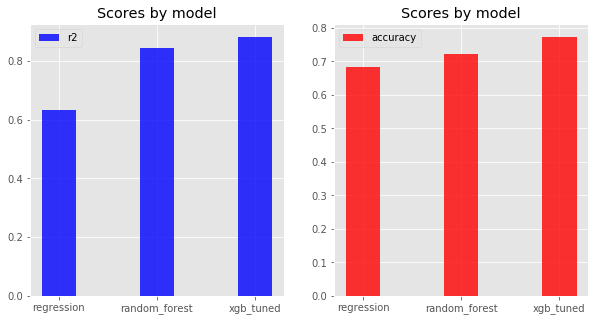

In [86]:
comparison_show()

As we can see, XGBoost tuned presents the best metrics by far. 

In [87]:
# here we plot the predictions of the various models against the actual values, so to compare them again.

def comparison_show_plots():

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(27, 22))

    ax1 = axs[0, 0]
    ax1.plot(y_test, y_test, "r--", y_test, y_pred_rm, "b,")
    ax1.set_title("Regression Model")

    ax2 = axs[0, 1]
    ax2.plot(y_test, y_test, "r--", y_test, y_pred_rf, "b,")
    ax2.set_title("Random Forest")

    ax1 = axs[1, 0]
    ax1.plot(y_test, y_test, "r--", y_test, y_pred_xgb_standard, "b,")
    ax1.set_title("XG Boost Standard")

    ax2 = axs[1, 1]
    ax2.plot(y_test, y_test, "r--", y_test, y_pred_xgb, "b,")
    ax2.set_title("XG Boost Tuned")


    plt.show()

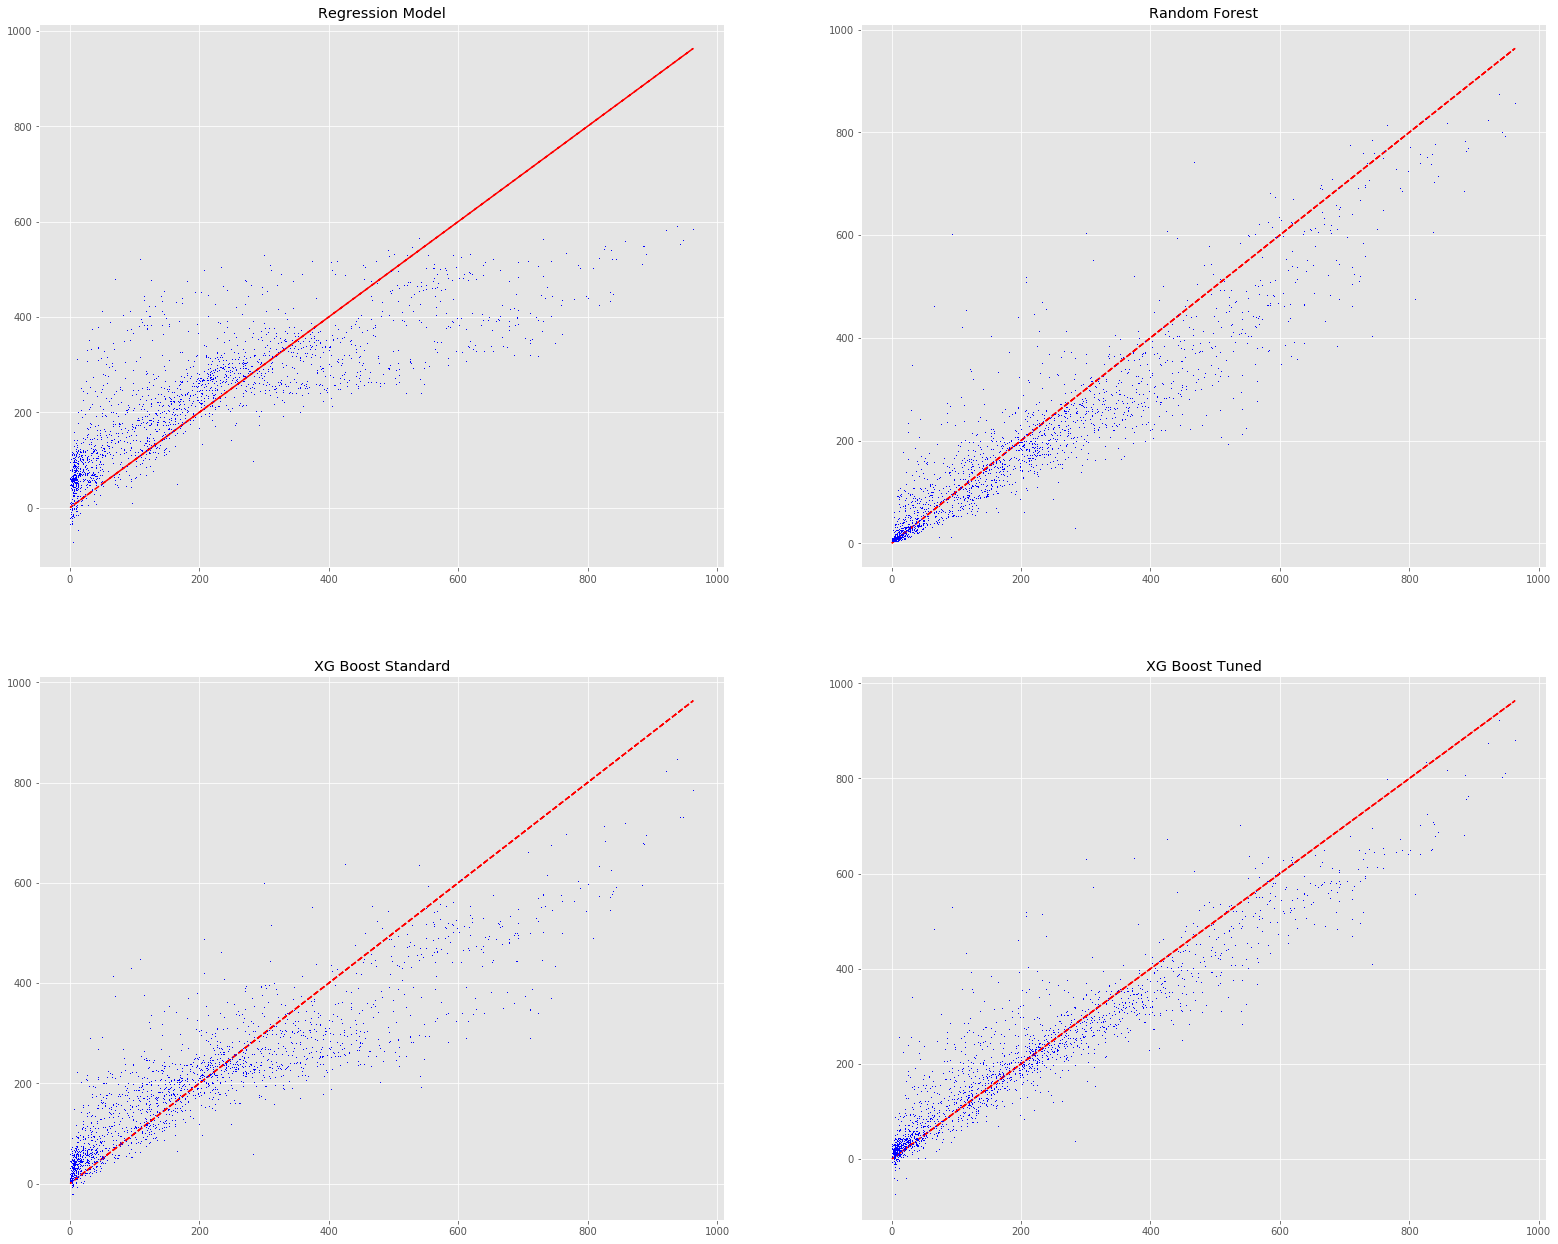

In [88]:
comparison_show_plots()

In [89]:
end_time = time.time()
elapsed = end_time - start

print ("Start", print_time(start))
print ("End", print_time(end_time))
print (print_time(elapsed))
# 18 Min 10 Elapsed with Dask

Start 06:35:16
End 06:53:26
00:18:10


As we can clearly see, XGBoost after tuning reaches the best results. Compared to the other models, the performance is sensibly higher. The increase in the R^2 of the XGBoost, through hyperparameter tuning, was the turning point which allowed us to reach predictions which are this good. 